In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from os import path as op
import nibabel as nb
import numpy as np
from scipy.stats import zscore
from mriqc.interfaces.functional import auto_mask, find_spikes
from mriqc.interfaces.functional import Spikes
import matplotlib.pyplot as plt

In [2]:
!ls data/

sub-51205_task-rest_bold_mcf_mask.nii.gz
sub-51205_task-rest_bold_mcf.nii.gz
sub-51210_task-rest_bold_mcf_mask.nii.gz
sub-51210_task-rest_bold_mcf.nii.gz
sub-51237_task-rest_bold_mcf_mask.nii.gz
sub-51237_task-rest_bold_mcf.nii.gz
sub-51258_task-rest_bold_mcf_mask.nii.gz
sub-51258_task-rest_bold_mcf.nii.gz
sub-51273_task-rest_bold_mcf_mask.nii.gz
sub-51273_task-rest_bold_mcf.nii.gz
sub-51277_task-rest_bold_mcf_mask.nii.gz
sub-51277_task-rest_bold_mcf.nii.gz
sub-ben01_task-unknown_bold_mask.nii.gz
sub-ben01_task-unknown_bold.nii.gz


In [11]:
sub_id = '51205'
func_name = op.abspath('./data/sub-ben01_task-unknown_bold.nii.gz')
mask_name = op.abspath('./data/sub-ben01_task-unknown_bold_mask.nii.gz')
#mask_name = op.abspath('./data/sub-{}_task-rest_bold_mcf_mask.nii.gz'.format(sub_id))
#func_name = './ABIDE-BIDS/sub-{0}/func/sub-{0}_task-rest_bold.nii.gz'.format(sub_id)
ntsteps = nb.load(func_name).get_shape()[-1]

/home/oesteban/miniconda2/envs/nipypedev-3.5/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: Please use the shape property instead of get_shape


In [14]:
sp_if = Spikes(in_file=func_name, in_mask=mask_name, out_tsz='brain.txt')
res = sp_if.run()

sp_if2 = Spikes(in_file=func_name, automask='chris', out_tsz='chris.txt', no_zscore=False)
res2 = sp_if2.run()

/home/oesteban/miniconda2/envs/nipypedev-3.5/lib/python3.5/site-packages/nipy/labs/mask.py:235: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  delta = sorted_input[limiteinf + 1:limitesup + 1] \
/home/oesteban/miniconda2/envs/nipypedev-3.5/lib/python3.5/site-packages/nipy/labs/mask.py:236: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  - sorted_input[limiteinf:limitesup]
/home/oesteban/miniconda2/envs/nipypedev-3.5/lib/python3.5/site-packages/nipy/labs/mask.py:238: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  threshold = 0.5 * (sorted_input[ia + limiteinf]
/home/oesteban/miniconda2/envs/nipypedev-3.5/lib/python3.5/site-packages/nipy/labs/mask.py:239: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  + sorted_input[i

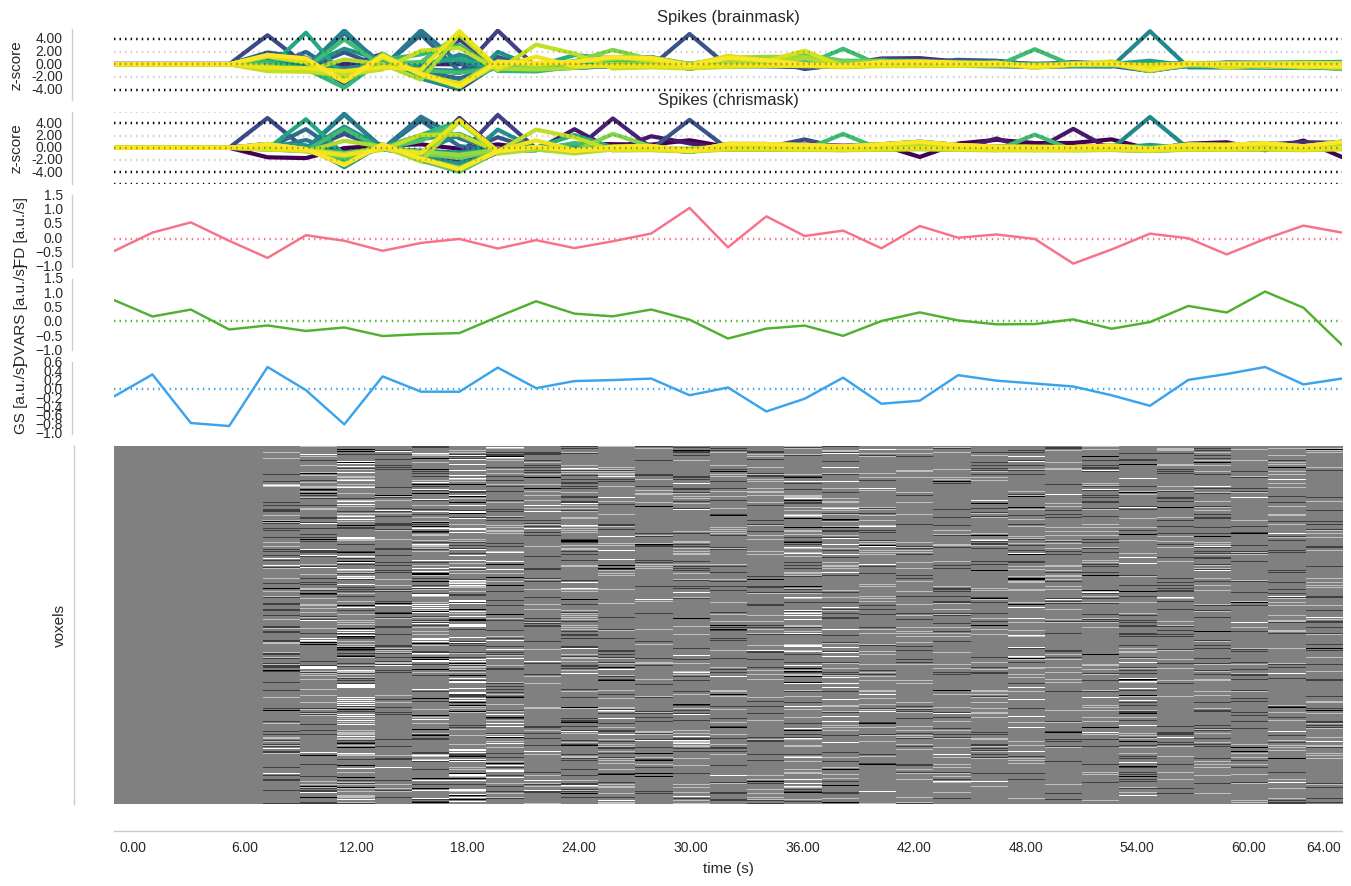

In [15]:
from mriqc.viz.fmriplots import fMRIPlot
myplot = fMRIPlot(func_name, mask_name)
myplot.add_spikes(res.outputs.out_tsz, 'Spikes (brainmask)')
myplot.add_spikes(res2.outputs.out_tsz, 'Spikes (chrismask)')
myplot.add_confounds(np.random.normal(size=(ntsteps,)), 'FD')
myplot.add_confounds(np.random.normal(size=(ntsteps,)), 'DVARS')
myplot.add_confounds(np.random.normal(size=(ntsteps,)), 'GS')
myplot.plot()